In [37]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import random
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
dpath = '.../Humana/data/'
train = pd.read_csv(dpath + 'HMAHCC_COMP.csv')
test = pd.read_csv(dpath + 'HMAHCC_HOLDOUT.csv')

C:\Users\LUQI\Anaconda3\envs\new_environment\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pos_ids = pd.read_csv(dpath + 'positive_id.csv', header = None)
neg_ids = pd.read_csv(dpath + 'negative_id.csv', header = None)

In [4]:
pos_ids['label'] = 1
neg_ids['label'] = 0

In [5]:
label = pd.concat([pos_ids, neg_ids], axis = 0)

In [6]:
label = label[[1, 'label']]

In [7]:
label.columns = [['id', 'label']]

In [8]:
train.shape, test.shape

((6086969, 20), (1480394, 20))

In [9]:
train_name = []
for i in train.columns:
    train_name.append(i.lower())

test_name = []
for i in test.columns:
    test_name.append(i.lower())

In [10]:
train.columns = train_name
test.columns = test_name
test = test[train_name]

In [11]:
train[train['days']<=0].shape

(2840228, 20)

In [12]:
train = train[train['days']<=0]

In [13]:
test[test['days']<=0].shape

(1480394, 20)

In [14]:
train['event_attr9'].fillna(0)

0           2.65
1           2.65
2           5.00
3           2.65
4           2.65
5           2.65
6           2.65
7           0.00
8           2.65
9           2.65
10          0.00
11          0.00
12          0.00
13          0.00
14          0.00
15          2.65
16          2.65
17          0.00
18          0.00
19          4.00
20          4.00
21          7.00
22         11.20
23          0.00
24          2.65
25          2.65
26          2.65
27          2.65
28          0.00
29          2.65
           ...  
6086854     5.00
6086855     7.98
6086856     5.00
6086857     7.98
6086858     5.00
6086859     3.10
6086860     4.00
6086861     8.20
6086862     1.86
6086863     4.00
6086864     7.53
6086865     7.53
6086866     1.86
6086867     4.00
6086868     7.53
6086869     1.86
6086870     4.00
6086871     1.86
6086872     0.00
6086873     0.00
6086874     0.00
6086875     4.00
6086876     1.86
6086877     4.00
6086878     1.86
6086879     4.00
6086880     1.86
6086881     4.

##### Construct Basic Features：

In [15]:
def get_basic_features(data):
    #Basic Features
    
    #How many records,all types
    data_feature = pd.DataFrame(data['id'].value_counts())
    data_feature.columns = ['all_counts']
    data_feature['id'] = list(data_feature.index)
    data_feature.index = range(data_feature.shape[0])
    
    #event_descr occurence
    temp = train.groupby(['id', 'event_descr']).size().unstack().reset_index()
    temp.columns = ['id'] + ['counts_' + x for x in temp.columns[1:]]
    temp_columns = list(temp.columns[1:])
    
    #how many event_descr for each user
    temp['different_event_descr_counts'] = np.array(np.sum(pd.notnull(temp[temp_columns]), axis = 1))
    temp = temp.fillna(0)
    
    #event_descr statistics（max，std，mean，avg）
    temp['descr_counts_max'] = np.max(temp[temp_columns], axis = 1)
    temp['descr_counts_mean'] = np.mean(temp[temp_columns], axis = 1)
    temp['descr_counts_std'] = np.std(temp[temp_columns], axis = 1)
    temp['descr_counts_median'] = np.median(temp[temp_columns].fillna(0), axis = 1)
    
    #merge features above
    data_feature = pd.merge(data_feature, temp, how = 'left', on = 'id')
    #Get['event_descr'] == 'RX Claim - Paid' or MME is not null，
    #Since MME is related to positive sample
    temp_MME = data[(data['event_descr'] == 'RX Claim - Paid')&(pd.notnull(data['mme']))]
    
    #mme occurence
    temp = temp_MME.groupby(['id']).size().reset_index()
    temp.columns = ['id', 'counts_paid_mme']
    #mme sum
    temp2 = temp_MME.groupby(['id'])['mme'].sum().reset_index()
    temp2.columns = ['id', 'paid_mme_sum']
    temp = pd.merge(temp, temp2, how = 'left', on = 'id')
    #mme avg
    temp2 = temp_MME.groupby(['id'])['mme'].mean().reset_index()
    temp2.columns = ['id', 'paid_mme_mean']
    temp = pd.merge(temp, temp2, how = 'left', on = 'id')
    #mme variance
    temp2 = temp_MME.groupby(['id'])['mme'].std().reset_index()
    temp2.columns = ['id', 'paid_mme_std']
    temp = pd.merge(temp, temp2, how = 'left', on = 'id')
     #mme max
    temp2 = temp_MME.groupby(['id'])['mme'].max().reset_index()
    temp2.columns = ['id', 'paid_mme_max']
    temp = pd.merge(temp, temp2, how = 'left', on = 'id')
    
    #merge all the features
    data_feature = pd.merge(data_feature, temp, how = 'left', on = 'id')
    
    
    #Collect frequence record and discover the pattern
    name1_ = []
    for day in [0, -30, -60, -90, -120, -150, -180, -210, -240, -270, -300]:
        temp = data[data['days']>=day]
        temp = temp.groupby(['id']).size().reset_index()
        temp.columns = ['id'] + [str(day) + '_counts_' + str(x) for x in temp.columns[1:]]
        data_feature = pd.merge(data_feature, temp, how = 'left', on = 'id')
        name1_ = list(temp.columns[1:])
    
    name2_ = []    
    for day in [0, -30, -60, -90, -120, -150, -180, -210, -240, -270, -300]:
        temp = data[data['days']>=day]
        temp = temp.groupby(['id', 'event_descr']).size().unstack().reset_index()
        temp.columns = ['id'] + [str(day) + '_counts_event_descr_' + str(x) for x in temp.columns[1:]]
        data_feature = pd.merge(data_feature, temp, how = 'left', on = 'id')
        name2_ = list(temp.columns[1:])
    
    #sum,avg,max,variance
    data_feature['mean_bytime_counts'] = np.mean(data_feature[name1_], axis = 1)
    data_feature['max_bytime_counts'] = np.max(data_feature[name1_], axis = 1)
    data_feature['std_bytime_counts'] = np.std(data_feature[name1_], axis = 1)
    
    
    data_feature['mean_bytime_counts_descr'] = np.mean(data_feature[name2_], axis = 1)
    data_feature['max_bytime_counts_descr'] = np.max(data_feature[name2_], axis = 1)
    data_feature['std_bytime_counts_descr'] = np.std(data_feature[name2_], axis = 1)
    
    
    #att9 cost
    data['event_attr9'] = data['event_attr9'].fillna(0)
    temp = data.groupby(['id'])['event_attr9'].sum().reset_index()
    temp.columns = ['id', 'event_attr9_sum']
    data_feature = pd.merge(data_feature, temp, how = 'left', on = 'id')
    
    temp = data.groupby(['id'])['event_attr9'].mean().reset_index()
    temp.columns = ['id', 'event_attr9_mean']
    data_feature = pd.merge(data_feature, temp, how = 'left', on = 'id')
    
    temp = data.groupby(['id'])['event_attr9'].std().reset_index()
    temp.columns = ['id', 'event_attr9_std']
    data_feature = pd.merge(data_feature, temp, how = 'left', on = 'id')
    
    #drug_type
    temp = data.groupby(['id', 'drug_type']).size().unstack().reset_index()
    data_feature = pd.merge(data_feature, temp, how = 'left', on = 'id')
    print(data_feature.shape)
    
    #attri_2 place of treatment
    d = data.groupby(['id', 'event_attr2']).size().unstack().reset_index()
    event_attr2_freq = pd.DataFrame(train['event_attr2'].value_counts())
    top_event_attr2_freq = list(event_attr2_freq.index)[:30]
    top_event_attr2_freq = ['id'] + top_event_attr2_freq
    d = d[top_event_attr2_freq]
    data_feature = pd.merge(data_feature, d, how = 'left', on = 'id')
    print(data_feature.shape)
    return data_feature

In [16]:
train_fe = get_basic_features(train)

(14000, 226)
(14000, 256)


In [17]:
test_fe = get_basic_features(test)

(6000, 226)
(6000, 256)


In [18]:
train_fe.shape, test_fe.shape

((14000, 256), (6000, 256))

In [19]:
test_fe.columns

Index(['all_counts', 'id', 'counts_Fully Paid Claim',
       'counts_Inbound Call by Mbr', 'counts_Inbound Call by Other',
       'counts_Inbound Call by Prov', 'counts_New diagnosis - CAD',
       'counts_New diagnosis - CHF', 'counts_New diagnosis - CPD',
       'counts_New diagnosis - Diabetes',
       ...
       'RIGHTSOURCE CAMPAIGN/DMS', 'CHECK INFO/RECOUPMENT',
       'PRIOR AUTHORIZATION', 'PHYSICIAN SERVICES', 'STATUS',
       'OPIOID AGONISTS', 'NURSING FACILITY', 'REQUEST',
       'GLUCOCORTICOSTEROIDS', 'CLAIMS STATUS'],
      dtype='object', length=256)

In [20]:
train_fe.columns

Index(['all_counts', 'id', 'counts_Fully Paid Claim',
       'counts_Inbound Call by Mbr', 'counts_Inbound Call by Other',
       'counts_Inbound Call by Prov', 'counts_New diagnosis - CAD',
       'counts_New diagnosis - CHF', 'counts_New diagnosis - CPD',
       'counts_New diagnosis - Diabetes',
       ...
       'RIGHTSOURCE CAMPAIGN/DMS', 'CHECK INFO/RECOUPMENT',
       'PRIOR AUTHORIZATION', 'PHYSICIAN SERVICES', 'STATUS',
       'OPIOID AGONISTS', 'NURSING FACILITY', 'REQUEST',
       'GLUCOCORTICOSTEROIDS', 'CLAIMS STATUS'],
      dtype='object', length=256)

In [21]:
label.shape

(14000, 2)

In [22]:
label.index = range(label.shape[0])

In [23]:
train_fe = pd.merge(train_fe, label, how = 'left', on = 'id')

In [24]:
train_fe['label'].value_counts()

0    9963
1    4037
Name: label, dtype: int64

In [25]:
list_ = list(range(train_fe.shape[0]))

In [26]:
test

,id,event_descr,event_attr1,event_attr2,event_attr3,event_attr4,event_attr5,event_attr6,event_attr7,event_attr8,event_attr9,event_attr10,days,pay_day_supply_cnt,payable_qty,mme,drug_type,specialty,specialty2,specialty3
0,ID98975196852,RX Claim - Rejected,DENY DUE TO ERRORS,"SYMPTOMS, SIGNS, ILL DEFINED CONDITIONS",NO DUAL COVERAGE,COPAY EXCEPTIONS,AMBIEN,ZOLPIDEM TARTRATE TAB 10 MG,2.45421e+07,180,510.00,NaN,-964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID98975196852,RX Claim - Rejected,DENY DUE TO ERRORS,"SYMPTOMS, SIGNS, ILL DEFINED CONDITIONS",NO DUAL COVERAGE,COPAY EXCEPTIONS,AMBIEN,ZOLPIDEM TARTRATE TAB 10 MG,2.45421e+07,90,255.00,NaN,-964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID98975196852,RX Claim - Rejected,PRE-AUTH CLM,"SYMPTOMS, SIGNS, ILL DEFINED CONDITIONS",NO DUAL COVERAGE,COPAY EXCEPTIONS,AMBIEN,ZOLPIDEM TARTRATE TAB 10 MG,2.45421e+07,10,63.15,NaN,-964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID98975196852,RX Claim - New Drug,492700,PROTON PUMP INHIBITORS,OMEPRAZOLE,006,GASTRO,NaN,NaN,OMEPRAZOLE CAP DELAYED RELEASE 20 MG,7.15,49270060.0,-963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID98975196852,RX Claim - Paid,PROTON PUMP INHIBITORS,NaN,7.15,0,OMEPRAZOLE,GASTRO,NaN,OMEPRAZOLE CAP DELAYED RELEASE 20 MG,7.15,49270060.0,-963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ID98975196852,RX Claim - Rejected,DENY DUE TO ERRORS,"SYMPTOMS, SIGNS, ILL DEFINED CONDITIONS",NO DUAL COVERAGE,COPAY EXCEPTIONS,LEXAPRO,ESCITALOPRAM OXALATE TAB 5 MG (BASE EQUIV),4.56201e+08,90,255.00,NaN,-963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ID98975196852,RX Claim - Rejected,PRE-AUTH CLM,"SYMPTOMS, SIGNS, ILL DEFINED CONDITIONS",NO DUAL COVERAGE,COPAY EXCEPTIONS,LEXAPRO,ESCITALOPRAM OXALATE TAB 5 MG (BASE EQUIV),4.56201e+08,5,34.58,NaN,-963,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ID98975196852,RX Claim - New Drug,581600,SELECTIVE SEROTONIN REUPTAKE INHIBITORS (SSRIS),LEXAPRO,004,PSYCH-DEP,NaN,NaN,ESCITALOPRAM OXALATE TAB 5 MG (BASE EQUIV),119.58,58160034.0,-962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ID98975196852,RX Claim - New Drug,602040,NON-BARBITURATE HYPNOTICS,AMBIEN,013,NUISANCE-SLEEP,NaN,NaN,ZOLPIDEM TARTRATE TAB 10 MG,150.42,60204080.0,-962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ID98975196852,RX Claim - Paid,NON-BARBITURATE HYPNOTICS,NaN,186.14,35.72,AMBIEN,NUISANCE-SLEEP,NaN,ZOLPIDEM TARTRATE TAB 10 MG,150.42,60204080.0,-962,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
k = 10
kfold = pd.DataFrame()
kfold['id'] = list(train_fe.index)
kfold['kfolds'] = list(range(k))*(train_fe.shape[0]//k) + list(range(k))[:train_fe.shape[0]%k]

In [28]:
auc_list = []
pred_all = pd.DataFrame(test_fe['id'])
for i in range(k):
    
    print('***********No.%sfold*************'%i)
    train_idx = list(kfold[kfold['kfolds'] != i]['id'])
    test_idx = list(kfold[kfold['kfolds'] == i]['id'])
    
    train_X = train_fe.iloc[train_idx, :].drop(['id', 'label'], axis = 1)
    test_X =  train_fe.iloc[test_idx, :].drop(['id', 'label'], axis = 1)
    
    train_y = train_fe.iloc[train_idx, :]['label']
    test_y = train_fe.iloc[test_idx, :]['label']
    
    print('train positive/negative ratio')
    print(np.sum(train_y)/len(train_y))
    print(np.sum(test_y)/len(test_y))
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_test = lgb.Dataset(test_X, test_y)
    
    params_ = {'metric': 'auc', 'learning_rate' : 0.05, \
          'max_depth': -1,  'objective': 'binary', 
          'feature_fraction': 0.85,'bagging_fraction': 0.85,\
          'bagging_freq': 10,  #'min_data': 500, #'num_leaves': 37,\
         'boosting_type': 'gbdt', 'lambda_l2': 0, 'lambda_l1': 0}
    
    lgb_model = lgb.train(params_,train_set=lgb_train, num_boost_round=5000,
                        valid_sets= lgb_test,
                      verbose_eval=50, early_stopping_rounds=500)
    
    current_auc = roc_auc_score(test_y, lgb_model.predict(test_X, num_iteration=lgb_model.best_iteration))
    auc_list.append(current_auc)
    pred = pd.DataFrame(lgb_model.predict(test_fe[train_X.columns], num_iteration=lgb_model.best_iteration))
    pred_all = pd.concat([pred_all, pred], axis = 1)
    print(pred_all.shape)
    print('current average AUC')
    print(np.mean(auc_list))

***********No.0fold*************
train positive/negative ratio
0.2888095238095238
0.2842857142857143
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.731108
[100]	valid_0's auc: 0.731116
[150]	valid_0's auc: 0.729368
[200]	valid_0's auc: 0.72492
[250]	valid_0's auc: 0.721304
[300]	valid_0's auc: 0.721324
[350]	valid_0's auc: 0.719904
[400]	valid_0's auc: 0.718285
[450]	valid_0's auc: 0.716707
[500]	valid_0's auc: 0.71766
[550]	valid_0's auc: 0.7159
Early stopping, best iteration is:
[69]	valid_0's auc: 0.734528
(6000, 2)
current average AUC
0.7345284305760338
***********No.1fold*************
train positive/negative ratio
0.2892063492063492
0.2807142857142857
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.742742
[100]	valid_0's auc: 0.741729
[150]	valid_0's auc: 0.745163
[200]	valid_0's auc: 0.741704
[250]	valid_0's auc: 0.740996
[300]	valid_0's auc: 0.742161
[350]	valid_0's auc: 0.742669
[400]	valid_0's auc: 0.7392

In [29]:
auc_list = []
pred_all = pd.DataFrame(test_fe['id'])
for i in range(k):
    
    print('***********No.%sfold*************'%i)
    train_idx = list(kfold[kfold['kfolds'] != i]['id'])
    test_idx = list(kfold[kfold['kfolds'] == i]['id'])
    
    train_X = train_fe.iloc[train_idx, :].drop(['id', 'label'], axis = 1)
    test_X =  train_fe.iloc[test_idx, :].drop(['id', 'label'], axis = 1)
    
    train_y = train_fe.iloc[train_idx, :]['label']
    test_y = train_fe.iloc[test_idx, :]['label']
    
    print('train positive/negative ratio')
    print(np.sum(train_y)/len(train_y))
    print(np.sum(test_y)/len(test_y))
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_test = lgb.Dataset(test_X, test_y)
    
    params_ = {'metric': 'auc', 'learning_rate' : 0.005, \
          'max_depth': -1,  'objective': 'binary', 
          'feature_fraction': 0.85,'bagging_fraction': 0.85,\
          'bagging_freq': 10,  #'min_data': 500, #'num_leaves': 37,\
         'boosting_type': 'gbdt', 'lambda_l2': 0, 'lambda_l1': 0}
    
    lgb_model = lgb.train(params_,train_set=lgb_train, num_boost_round=5000,
                        valid_sets= lgb_test,
                      verbose_eval=50, early_stopping_rounds=500)
    
    current_auc = roc_auc_score(test_y, lgb_model.predict(test_X, num_iteration=lgb_model.best_iteration))
    auc_list.append(current_auc)
    pred = pd.DataFrame(lgb_model.predict(test_fe[train_X.columns], num_iteration=lgb_model.best_iteration))
    pred_all = pd.concat([pred_all, pred], axis = 1)
    print(pred_all.shape)
    print('current average AUC')
    print(np.mean(auc_list))

***********No.0fold*************
train positive/negative ratio
0.2888095238095238
0.2842857142857143
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.728138
[100]	valid_0's auc: 0.729112
[150]	valid_0's auc: 0.731883
[200]	valid_0's auc: 0.732638
[250]	valid_0's auc: 0.733438
[300]	valid_0's auc: 0.734388
[350]	valid_0's auc: 0.735338
[400]	valid_0's auc: 0.73493
[450]	valid_0's auc: 0.735526
[500]	valid_0's auc: 0.736625
[550]	valid_0's auc: 0.736118
[600]	valid_0's auc: 0.736572
[650]	valid_0's auc: 0.736853
[700]	valid_0's auc: 0.736916
[750]	valid_0's auc: 0.73683
[800]	valid_0's auc: 0.737023
[850]	valid_0's auc: 0.736868
[900]	valid_0's auc: 0.737442
[950]	valid_0's auc: 0.73752
[1000]	valid_0's auc: 0.737475
[1050]	valid_0's auc: 0.737349
[1100]	valid_0's auc: 0.737477
[1150]	valid_0's auc: 0.73742
[1200]	valid_0's auc: 0.736943
[1250]	valid_0's auc: 0.73684
[1300]	valid_0's auc: 0.737415
[1350]	valid_0's auc: 0.737425
[1400]	valid_0's auc: 0.7

[1200]	valid_0's auc: 0.754212
[1250]	valid_0's auc: 0.753842
[1300]	valid_0's auc: 0.754768
[1350]	valid_0's auc: 0.754533
[1400]	valid_0's auc: 0.754135
[1450]	valid_0's auc: 0.753533
[1500]	valid_0's auc: 0.753506
[1550]	valid_0's auc: 0.753315
[1600]	valid_0's auc: 0.752574
[1650]	valid_0's auc: 0.752837
[1700]	valid_0's auc: 0.753076
[1750]	valid_0's auc: 0.75339
[1800]	valid_0's auc: 0.753448
Early stopping, best iteration is:
[1306]	valid_0's auc: 0.754937
(6000, 7)
current average AUC
0.7457789689015986
***********No.6fold*************
train positive/negative ratio
0.2899206349206349
0.2742857142857143
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.713225
[100]	valid_0's auc: 0.714669
[150]	valid_0's auc: 0.714221
[200]	valid_0's auc: 0.716815
[250]	valid_0's auc: 0.717812
[300]	valid_0's auc: 0.719096
[350]	valid_0's auc: 0.719319
[400]	valid_0's auc: 0.720985
[450]	valid_0's auc: 0.721646
[500]	valid_0's auc: 0.722128
[550]	valid_0's auc: 

In [30]:
pred_all['Predicted Value'] = np.mean(pred_all.iloc[:, 1:], axis = 1)

In [31]:
pred_all = pred_all[['id', 'Predicted Value']]
pred_all.columns = [['ID', 'Predicted Value']]

In [32]:
pred_all = pred_all.sort_values('Predicted Value', ascending=False)

In [33]:
pred_all['Individual Rank'] = range(1, pred_all.shape[0] + 1)

In [34]:
pred_all.index = range(pred_all.shape[0])

In [35]:
pred_all.shape

(6000, 3)

In [36]:
pred_all.to_csv('submission.csv', index = None, encoding = 'utf-8')

##### Feature Importance

In [36]:
m = sorted(zip(train_X.columns, lgb_model.feature_importance("gain")),key=lambda x: x[1], reverse=True)
m

[('counts_paid_mme', 52939.8292696476),
 ('paid_mme_sum', 46106.75403428078),
 ('ER', 20981.718786001205),
 ('OFFICE', 20510.363865852356),
 ('paid_mme_mean', 19677.154633522034),
 ('counts_Fully Paid Claim', 11516.055840969086),
 ('paid_mme_std', 10059.855929613113),
 ('ON CAMPUS-HOSPITAL OUTPATIENT', 8879.991873502731),
 ('paid_mme_max', 8169.76038813591),
 ('event_attr9_std', 7886.317644119263),
 ('event_attr9_mean', 7447.005487680435),
 ('INDEPENDENT LABORATORY', 7414.149920463562),
 ('0_counts_event_descr_Fully Paid Claim', 7163.705826759338),
 ('event_attr9_sum', 6953.993742227554),
 ('-300_counts_event_descr_RX Claim - Paid', 6428.083697319031),
 ('-300_counts_event_descr_RX Claim - Rejected', 6285.342708110809),
 ('INPATIENT HOSPITAL', 6235.488286733627),
 ('IR', 5498.15219950676),
 ('counts_RX Claim - Paid', 5353.071284532547),
 ('-270_counts_event_descr_RX Claim - Paid', 5213.294960021973),
 ('-30_counts_event_descr_Fully Paid Claim', 5063.51235127449),
 ('EMERGENCY ROOM - HO

In [37]:
import seaborn as sns

In [38]:
m2 = pd.DataFrame(m, columns=["Feature", "Importance_Score"])

In [39]:
m2

,Feature,Importance_Score
0,counts_paid_mme,52939.829270
1,paid_mme_sum,46106.754034
2,ER,20981.718786
3,OFFICE,20510.363866
4,paid_mme_mean,19677.154634
5,counts_Fully Paid Claim,11516.055841
6,paid_mme_std,10059.855930
7,ON CAMPUS-HOSPITAL OUTPATIENT,8879.991874
8,paid_mme_max,8169.760388
9,event_attr9_std,7886.317644


In [45]:
m3 = m2.drop(m2[m2.Importance_Score<1000].index)

In [46]:
m3

,Feature,Importance_Score
0,counts_paid_mme,52939.829270
1,paid_mme_sum,46106.754034
2,ER,20981.718786
3,OFFICE,20510.363866
4,paid_mme_mean,19677.154634
5,counts_Fully Paid Claim,11516.055841
6,paid_mme_std,10059.855930
7,ON CAMPUS-HOSPITAL OUTPATIENT,8879.991874
8,paid_mme_max,8169.760388
9,event_attr9_std,7886.317644


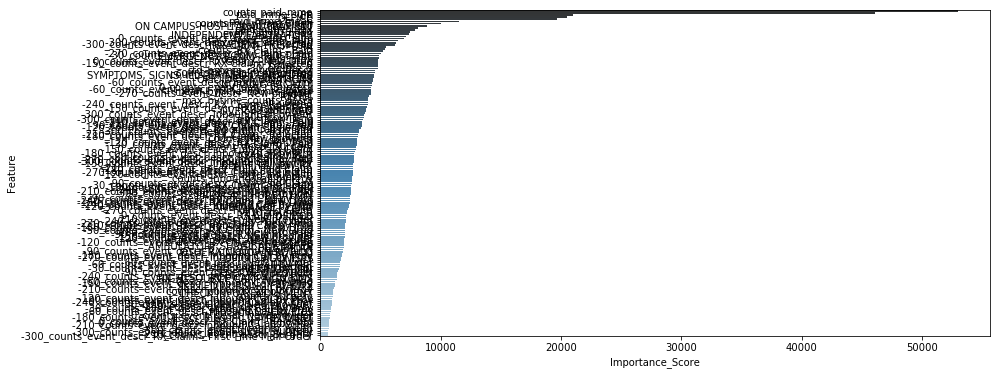

In [42]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Importance_Score", y="Feature", data=m3,palette="Blues_d")

In [ ]:
plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.title("Featurertances")
plt.show()

In [ ]:
pd.show_versions()